In [2]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import argparse
import random
import compress_pickle

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'grc_pattern_correlation_210111_spearman'

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot_data import MyPlotData
import tools2

# ap = argparse.ArgumentParser()
# ap.add_argument("--min_length", type=int, default=4)
# ap.add_argument("--max_dist", type=int, default=125)
# ap.add_argument("--n_random", type=int, default=20)
# config = ap.parse_args()
min_length = 6
max_dist = 150
n_random = 20


mf_grc_db = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/mf_grc/gen_201229_setup01_syndb_threshold_20_coalesced.gz')

from weight_database import WeightDatabase
weightdb = WeightDatabase()

weightdb.load_syn_db('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/grc_axons/gen_210111_setup01_syndb_threshold_10_coalesced_filtered_10.gz')
weightdb.load_touch_db(
#     '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/purkinje/grc_pc_touches_201224.gz',
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/purkinje/grc_pc_touches_210111.gz',
    max_dist=max_dist
    )

hist = defaultdict(list)

def calc_pattern_correlation(weightdb, nids, type='Data',
        skip_fn=None):
    mpd = MyPlotData()
    processed = set()
    n = 0
    random.seed(0)
    # while n < n_sample:
    #     nid0 = nids[int(random.random()*len(nids))]
    #     nid1 = nids[int(random.random()*len(nids))]
    for nid0 in nids:
        for nid1 in nids:
            if nid0 == nid1:
                continue
            if (nid0, nid1) in processed:
                continue
            if skip_fn and skip_fn(nid0, nid1):
                continue
            processed.add((nid0, nid1))
            processed.add((nid1, nid0))
            if len(weightdb.get_shared_presyns(nid0, nid1)) < min_length:
                continue
            score = weightdb.calc_pattern_correlation(nid0, nid1, spearman=True)
            # if score >= 0.7:
            #     print(f'{nid0} and {nid1}: {score}')
            if math.isnan(score):
                continue
                score = 0
            mpd.add_data_point(
                score=score,
                type=type,
                )
            n += 1
            hist[type].append(score)
    print(f'Num samples: {n}')
    return mpd


presyns = list(weightdb.get_presyn_ids())

shares = tools2.compute_mf_share(presyns, mf_grc_db)

def skip_for_share_x(nid0, nid1, share):
    if nid1 in shares[nid0][share]:
        return False
    return True

def skip_for_share_0(nid0, nid1):
    for s in shares[nid0]:
        if nid1 in shares[nid0][s]:
            return True
    return False

mpd_data_share0 = calc_pattern_correlation(weightdb, presyns,
    skip_fn=skip_for_share_0,
    type='0-share')

mpd_data_share1 = calc_pattern_correlation(weightdb, presyns,
    skip_fn=partial(skip_for_share_x, share=1),
    type='1-share')

mpd_data_share2 = calc_pattern_correlation(weightdb, presyns,
    skip_fn=partial(skip_for_share_x, share=2),
    type='2-share')

mpd_data_share3 = calc_pattern_correlation(weightdb, presyns,
    skip_fn=partial(skip_for_share_x, share=3),
    type='3-share')



Num samples: 35084
Num samples: 2780
Num samples: 227
Num samples: 15


Height: 4, Aspect: 1.5


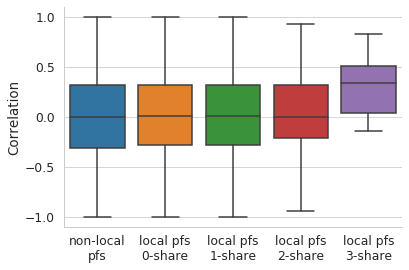

In [7]:

# (mpd_pfs_data, mpd_random) = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/pfs_pc_analysis/pfs_pattern_similarity_210101_random_test_max_dist_125_min_length_4_db.gz')
(mpd_pfs_data, _) = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/pfs_pc_analysis/pfs_pattern_correlation_210107_random_spearman_max_dist_150_min_length_6_db.gz')

mpd_all = MyPlotData()
# mpd_all.append(mpd_pfs_data, replace=[('type', 'remote pfs')])
mpd_all.append(mpd_pfs_data, replace=[('type', 'remote pfs')])
mpd_all.append(mpd_data_share0)
mpd_all.append(mpd_data_share1)
mpd_all.append(mpd_data_share2)
mpd_all.append(mpd_data_share3)
# # mpd_all.append(mpd_random)

# # mpd_all.append(mpd_random)
xticklabels = ['non-local\npfs', 'local pfs\n0-share', 'local pfs\n1-share', 'local pfs\n2-share', 'local pfs\n3-share']

# import compress_pickle
# compress_pickle.dump(
#     (mpd_data,
#         mpd_random),
#     f'{script_n}_max_dist_{config.max_dist}_min_length_{config.min_length}_db.gz',)


importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    y="score",
    x="type",
    # ylim=[.30, .70],
    context='paper',
    kind='box',
    # add_swarm=True,
    height=4,
    width=6,
    y_axis_label='Correlation',
    xticklabels=xticklabels,
    # x_axis_label='# of synapses per connection',
    save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )


In [14]:

hist = defaultdict(list)

for i, mpd_data_i in enumerate([mpd_data_share0, mpd_data_share1, mpd_data_share2, mpd_data_share3]):
    for e in mpd_data_i.data:
        assert not math.isnan(float(e['score']))
        hist[i].append(e['score'])

import scipy
fout_name = f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_n_{n_random}'
with open(f'{fout_name}_results', 'w') as fout:
    for foutt in [fout, sys.stdout]:
        for i in sorted(hist.keys()):
            for j in sorted(hist.keys()):
                if i >= j:
                    continue
                print(f'Comparing share-{i} to share-{j}', file=foutt)
                print(scipy.stats.ttest_ind(hist[i], hist[j]), file=foutt)
                print(scipy.stats.ranksums(hist[i], hist[j]), file=foutt)
                print(scipy.stats.mannwhitneyu(hist[i], hist[j], alternative='less'), file=foutt)
                print(scipy.stats.ks_2samp(hist[i], hist[j]), file=foutt)
                print(file=foutt)
                # print(scipy.stats.ks_2samp(hist[i], hist[j]), file=foutt)
    

Comparing share-0 to share-1
Ttest_indResult(statistic=-0.4735321179603601, pvalue=0.6358363225321872)
RanksumsResult(statistic=-0.5177615354723955, pvalue=0.6046246584219632)
MannwhitneyuResult(statistic=48479526.5, pvalue=0.3022953966987326)
KstestResult(statistic=0.012798922872874902, pvalue=0.7875886017803443)

Comparing share-0 to share-2
Ttest_indResult(statistic=-0.5296613114682321, pvalue=0.5963501067906676)
RanksumsResult(statistic=-0.4053286205952803, pvalue=0.6852359713383196)
MannwhitneyuResult(statistic=3919983.5, pvalue=0.3426046958711152)
KstestResult(statistic=0.05664893870820792, pvalue=0.44654625697952677)

Comparing share-0 to share-3
Ttest_indResult(statistic=-2.781064703925117, pvalue=0.00542098185965933)
RanksumsResult(statistic=-2.8036108026045516, pvalue=0.0050533865087001775)
MannwhitneyuResult(statistic=153133.0, pvalue=0.0025246575119605825)
KstestResult(statistic=0.3461691939345571, pvalue=0.041376440711443085)

Comparing share-1 to share-2
Ttest_indResult(s

In [10]:
import scipy.stats
scipy.stats.f_oneway(hist[0], hist[1], hist[2], hist[3])

F_onewayResult(statistic=2.742357322741428, pvalue=0.041559273007881786)

In [15]:

hist_pfs = []

for e in mpd_pfs_data.data:
#     if not math.isnan(e['score']):
        hist_pfs.append(float(e['score']))

import scipy
fout_name = f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_n_{n_random}'
with open(f'{fout_name}_results', 'a') as fout:
    for foutt in [fout, sys.stdout]:
        for i in sorted(hist.keys()):
                print(f'Comparing pfs to share-{i}', file=foutt)
                print(scipy.stats.ttest_ind(hist_pfs, hist[i]), file=foutt)
                print(scipy.stats.ranksums(hist_pfs, hist[i]), file=foutt)
                print(scipy.stats.mannwhitneyu(hist_pfs, hist[i], alternative='less'), file=foutt)
                print(scipy.stats.ks_2samp(hist[i], hist[j]), file=foutt)
                print(file=foutt)
                # print(scipy.stats.ks_2samp(hist_pfs, hist[i]), file=foutt)
    

Comparing pfs to share-0
Ttest_indResult(statistic=-0.7202673091254959, pvalue=0.4713641628216594)
RanksumsResult(statistic=-0.7886159590145649, pvalue=0.43033650051692407)
MannwhitneyuResult(statistic=174514589.5, pvalue=0.21514431414480362)
KstestResult(statistic=0.3461691939345571, pvalue=0.041376440711443085)

Comparing pfs to share-1
Ttest_indResult(statistic=-0.8083921731259585, pvalue=0.41887990599960145)
RanksumsResult(statistic=-0.886228441858791, pvalue=0.375494440235824)
MannwhitneyuResult(statistic=13747503.5, pvalue=0.18771907102523322)
KstestResult(statistic=0.3431654676258993, pvalue=0.045139972086124414)

Comparing pfs to share-2
Ttest_indResult(statistic=-0.6375494198552258, pvalue=0.5237813054981912)
RanksumsResult(statistic=-0.520002539682922, pvalue=0.603061804974135)
MannwhitneyuResult(statistic=1112127.0, pvalue=0.30150994044935464)
KstestResult(statistic=0.34126284875183555, pvalue=0.05760493814986822)

Comparing pfs to share-3
Ttest_indResult(statistic=-2.765521

In [18]:
import scipy.stats
scipy.stats.f_oneway(hist_pfs, hist[0], hist[1], hist[2], hist[3])

F_onewayResult(statistic=2.2142954601565834, pvalue=0.06478677176217315)

In [17]:
import scipy.stats
scipy.stats.kruskal(hist_pfs, hist[0], hist[1], hist[2], hist[3])

KruskalResult(statistic=9.028494626655178, pvalue=0.06039118370521954)